In [0]:
  %pip install scalecast
  %pip install statsmodels


Python interpreter will be restarted.
  Created wheel for scalecast: filename=SCALECAST-0.19.3-py3-none-any.whl size=123122 sha256=551d5ee52b0fe233d0e628a20c41ec6711405717e064986555575c69969c6f47
  Stored in directory: /root/.cache/pip/wheels/4b/a1/7f/2325ae5044ddd0c50c252042e0a857b8a2e6b52ff3620a5a54
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=59cf09a211398634562e1db5581288528807246a668f3bcc2fc63261088d0113
  Stored in directory: /root/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built scalecast eli5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Not uninstalling scikit-learn at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-c505ac50-aacb-47dd-a076-baf006918d6c
    Can't uninstall 'scikit-learn'. No files were found to uninstall.
  Attempting uninstall: jinja2
    Found existing installat

In [0]:
%run /Users/ebizindavyi@delhaize.be/Data_preparation/Parse_xls_files

In [0]:
from scalecast.Forecaster import Forecaster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scalecast.auxmodels import auto_arima
from lightgbm import LGBMRegressor
import datetime as dt

## Load the inbound data

In [0]:
inbound_2022_dir = '/dbfs/mnt/dataplatform/acc/DataScience/sandbox/ebiz/Inbound_FC/data/input/Ecom-Ops-status_2022.xlsx'

In [0]:
inbound_2022_df = create_master_df(inbound_2022_dir)

In [0]:
inbound_2022_df

,Dates,Dry Fc,Dry Actuals,Fresh Fc,Fresh,Frozen Fc,Frozen,Ultrafresh Fc,Ultrafresh
0,2022-01-03,85794.442754,84224.0,60969.286307,41000.0,49273.053738,5581.0,6538.217201,6538.217201
1,2022-01-04,65323.939111,49564.0,68517.000793,64233.0,6447.045743,6110.0,7288.014352,9673.000000
2,2022-01-05,59060.496963,45890.0,59891.490569,61162.0,14752.884950,6061.0,8645.127518,9394.000000
3,2022-01-06,54098.434315,26976.0,54044.997867,55700.0,11884.161805,5042.0,8733.406013,7299.000000
4,2022-01-07,48633.525710,37044.0,48691.064872,49534.0,7322.811052,5979.0,7745.598367,8240.000000
...,...,...,...,...,...,...,...,...,...
293,2022-12-27,71459.270000,63764.0,67049.998422,68912.0,6642.104962,5615.0,9028.927578,11033.000000
294,2022-12-28,71916.320000,47680.0,62406.358606,57239.0,5883.382433,5253.0,9509.601394,10525.000000
295,2022-12-29,60346.346000,39552.0,76619.568000,63748.0,5951.031775,6037.0,9399.318000,10458.000000
296,2022-12-30,52203.888000,61119.0,65006.548000,42234.0,5759.074282,6692.0,9096.132000,7824.000000


### Create yearly time series
needed to fill in date gaps

In [0]:
calendar_2022 = pd.DataFrame({'Dates':pd.date_range(dt.datetime(2022,1,3), periods=363, freq='d')})
inbound_2022_dry = calendar_2022.merge(inbound_2022_df, on='Dates',how='left').fillna(0).set_index('Dates').copy()
inbound_2022_dry = inbound_2022_dry.groupby(['Dates'])['Dry Actuals'].sum()
inbound_2022_dry

Out[18]: Dates
2022-01-03    84224.0
2022-01-04    49564.0
2022-01-05    45890.0
2022-01-06    26976.0
2022-01-07    37044.0
               ...   
2022-12-27    63764.0
2022-12-28    47680.0
2022-12-29    39552.0
2022-12-30    61119.0
2022-12-31    46818.0
Name: Dry Actuals, Length: 363, dtype: float64

## Create forecasting element

In [0]:
inbound_f_element = Forecaster(
    y = inbound_2022_dry,
    current_dates = inbound_2022_dry.index,
    future_dates = 14,
    cis = False,
    metrics = ['rmse','mae','mape','r2']
)

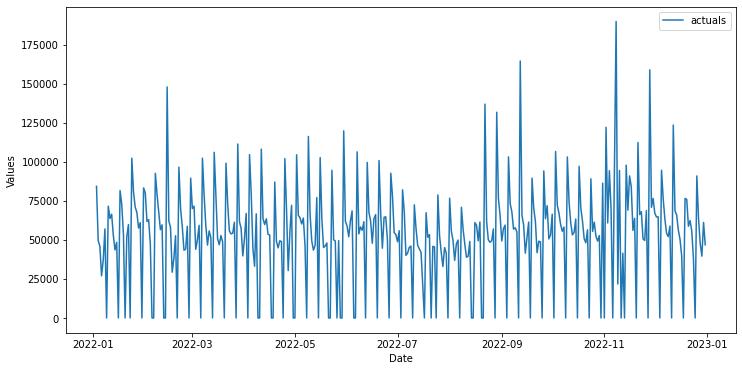

In [0]:
# display the entire series
inbound_f_element.plot()
plt.show()

check any seasonal or cyclic patterns existing in the data 

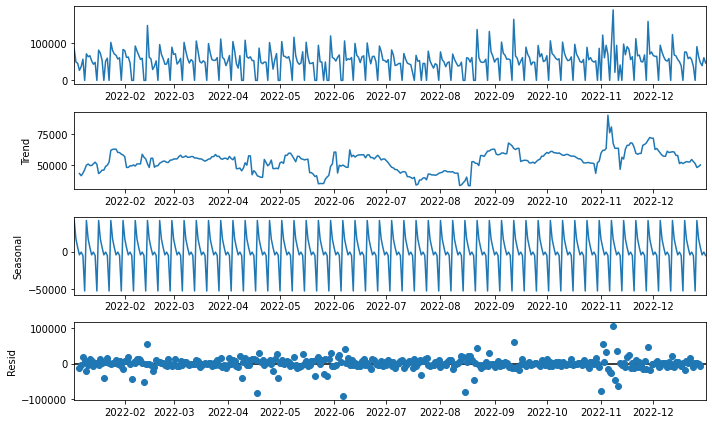

In [0]:
plt.rc("figure",figsize=(10,6))
inbound_f_element.seasonal_decompose().plot()
plt.show()

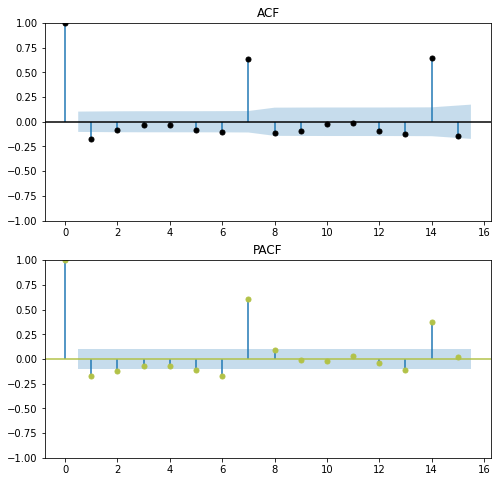

In [0]:
#mathematical proof
figs, axs = plt.subplots(2, 1,figsize=(8,8))
inbound_f_element.plot_acf(ax=axs[0],title='ACF',lags=15,color='black')
inbound_f_element.plot_pacf(ax=axs[1],title='PACF',lags=15,color='#B2C248',method='ywm')
plt.show()

### Set the parameters 
Paremetize the forecast objects, the more features and parameters we set, the more we help the model to better performance

In [0]:
#Test set 
inbound_f_element.set_test_length(.20)

In [0]:
inbound_f_element.eval_cis(
    mode = True,
    cilevel = .95,
)

In [0]:
inbound_f_element.add_seasonal_regressors('week',raw=False,sincos=True)

In [0]:
#Add autoregressive term, consider 
inbound_f_element.add_ar_terms(14)

### ARIMA model

In [0]:
%%time
auto_arima(inbound_f_element,test='adf',seasonal=True,dynamic_testing=14,m=7,error_action="ignore")

CPU times: user 3min 48s, sys: 4min 15s, total: 8min 3s
Wall time: 3min 4s


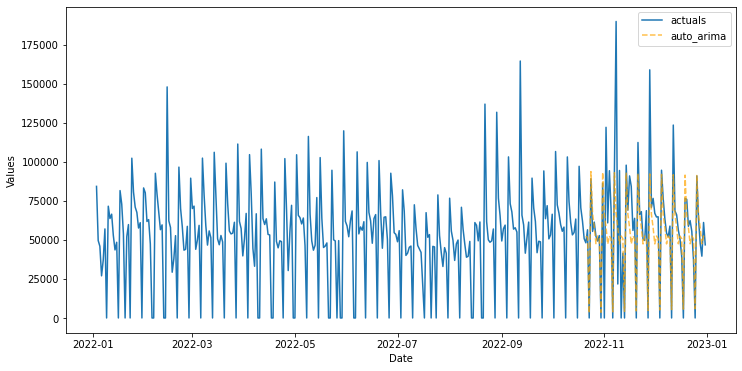

In [0]:
inbound_f_element.plot_test_set(models=['auto_arima'],ci=False,order_by='TestSetRMSE')
plt.show()

## lightgbm model 

In [0]:
%%time
inbound_f_element.set_estimator('lightgbm')
inbound_f_element.manual_forecast(max_depth=2,dynamic_testing=14)

CPU times: user 8.74 s, sys: 1.9 s, total: 10.6 s
Wall time: 9.98 s


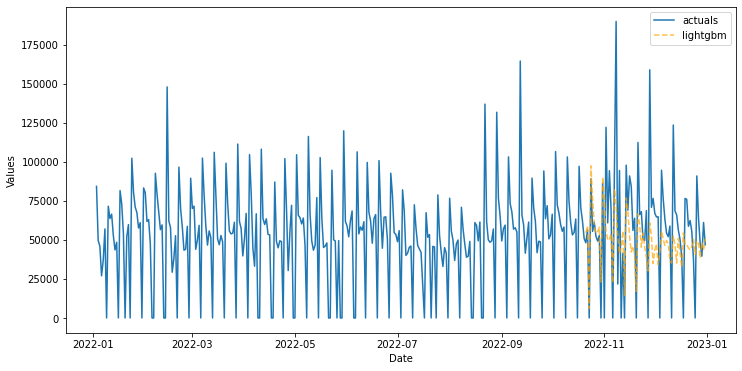

In [0]:
inbound_f_element.plot_test_set(models=['lightgbm'],ci=False,order_by='TestSetRMSE')
plt.show()

In [0]:
#max_depth= 3
inbound_f_element.set_estimator('lightgbm')
inbound_f_element.manual_forecast(call_me='lightgbm_2',max_depth=3,dynamic_testing=14)

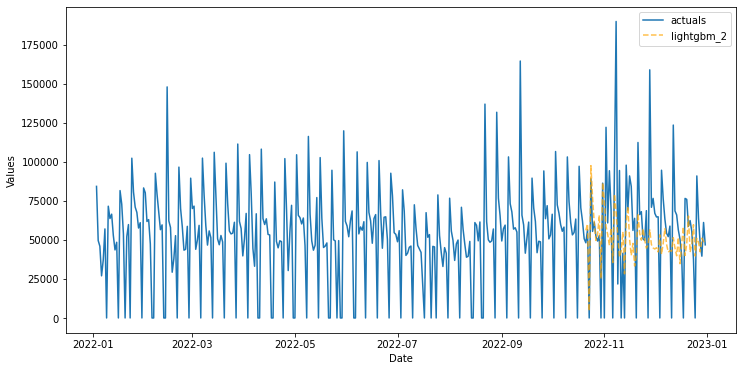

In [0]:
inbound_f_element.plot_test_set(models=['lightgbm_2'],ci=False)
plt.show()

In [0]:
#max_depth= 5
inbound_f_element.set_estimator('lightgbm')
inbound_f_element.manual_forecast(call_me='lightgbm_3',max_depth=5,dynamic_testing=14)

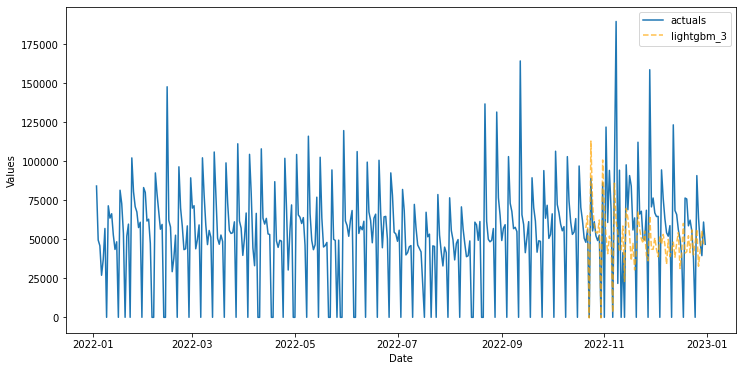

In [0]:
inbound_f_element.plot_test_set(models=['lightgbm_3'],ci=False)
plt.show()

### KNN model

In [0]:
# test the knn 
inbound_f_element.set_estimator('knn')
inbound_f_element.manual_forecast(n_neighbors=6,dynamic_testing=14)

Out[36]: <AxesSubplot:xlabel='Date', ylabel='Values'>

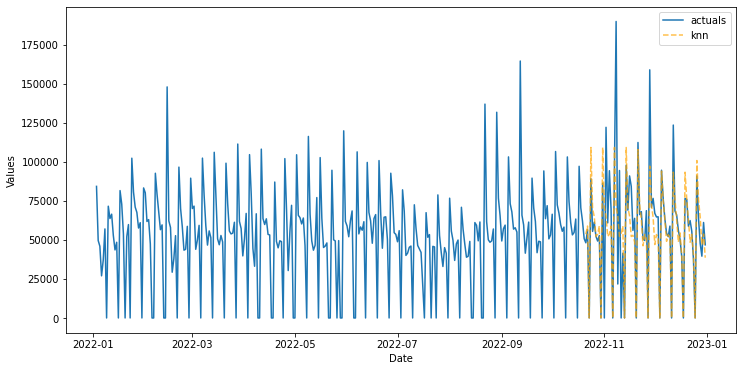

In [0]:
inbound_f_element.plot_test_set(models=['knn'],ci=False,order_by='TestSetRMSE')

In [0]:
inbound_f_element.set_estimator('knn')
inbound_f_element.manual_forecast(call_me='knn_2',n_neighbors=2,dynamic_testing=14)

Out[48]: <AxesSubplot:xlabel='Date', ylabel='Values'>

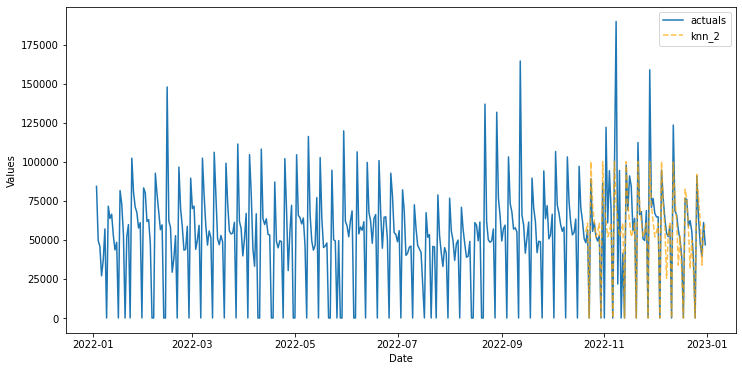

In [0]:
inbound_f_element.plot_test_set(models=['knn_2'],ci=False,order_by='TestSetRMSE')

In [0]:
inbound_f_element.set_estimator('knn')
inbound_f_element.manual_forecast(call_me='knn_3',n_neighbors=14,dynamic_testing=14)

Out[40]: <AxesSubplot:xlabel='Date', ylabel='Values'>

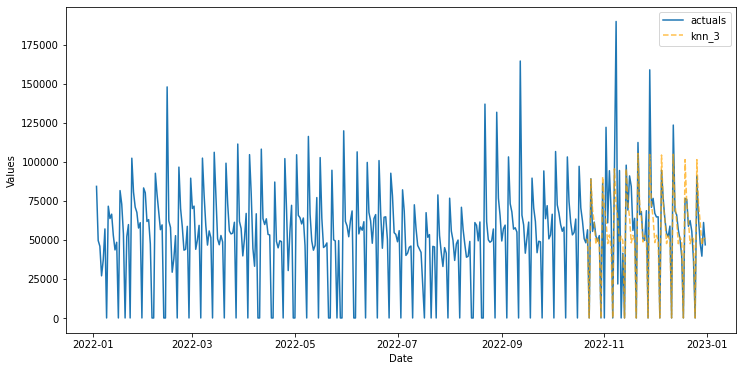

In [0]:
inbound_f_element.plot_test_set(models=['knn_3'],ci=False,order_by='TestSetRMSE')

In [0]:
inbound_f_element.set_estimator('knn')
inbound_f_element.manual_forecast(call_me='knn_4',n_neighbors=21,dynamic_testing=14)

Out[42]: <AxesSubplot:xlabel='Date', ylabel='Values'>

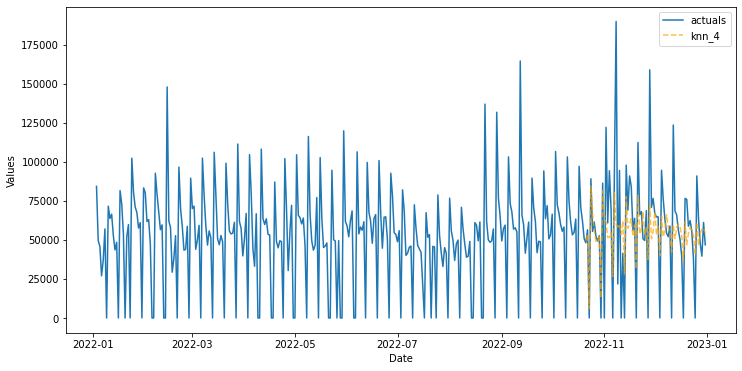

In [0]:
inbound_f_element.plot_test_set(models=['knn_4'],ci=False,order_by='TestSetRMSE')

Out[43]: <AxesSubplot:xlabel='Date', ylabel='Values'>

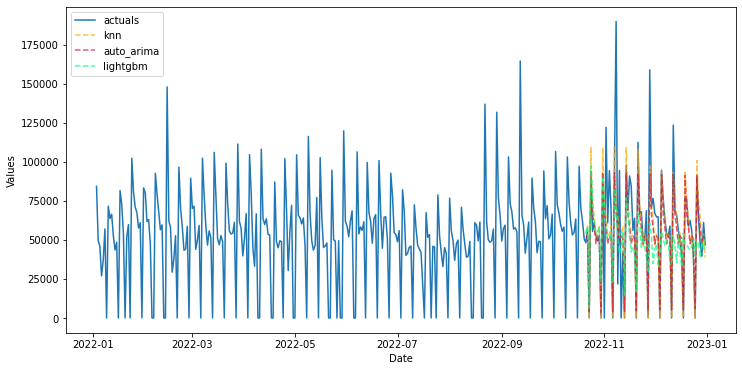

In [0]:
inbound_f_element.plot_test_set(models=['auto_arima','knn','lightgbm'],ci=False,order_by='TestSetRMSE')

In [0]:
inbound_f_element.export('model_summaries')

,ModelNickname,Estimator,Xvars,HyperParams,Observations,DynamicallyTested,TestSetLength,CILevel,ValidationMetric,ValidationMetricValue,models,weights,best_model,InSampleRMSE,InSampleMAE,InSampleMAPE,InSampleR2,TestSetRMSE,TestSetMAE,TestSetMAPE,TestSetR2
0,auto_arima,arima,[],"{'order': (2, 0, 0), 'seasonal_order': (2, 0, ...",363,1,72,0.95,NaN,NaN,NaN,NaN,True,19992.805177,12229.284537,NaN,0.619462,24854.283384,14460.747112,NaN,0.540717
1,lightgbm,lightgbm,"[weeksin, weekcos, AR1, AR2, AR3, AR4, AR5, AR...",{'max_depth': 2},363,14,72,0.95,NaN,NaN,NaN,NaN,False,14953.881240,9352.461287,NaN,0.790714,33164.112789,24668.500520,NaN,0.182261
2,lightgbm_2,lightgbm,"[weeksin, weekcos, AR1, AR2, AR3, AR4, AR5, AR...",{'max_depth': 3},363,14,72,0.95,NaN,NaN,NaN,NaN,False,11753.623704,7343.710644,NaN,0.870707,35155.546222,26314.894116,NaN,0.081106
3,lightgbm_3,lightgbm,"[weeksin, weekcos, AR1, AR2, AR3, AR4, AR5, AR...",{'max_depth': 5},363,14,72,0.95,NaN,NaN,NaN,NaN,False,8377.556640,5208.800720,NaN,0.934315,34988.587710,26017.002923,NaN,0.089813
4,knn,knn,"[weeksin, weekcos, AR1, AR2, AR3, AR4, AR5, AR...",{'n_neighbors': 6},363,14,72,0.95,NaN,NaN,NaN,NaN,False,17096.014664,9802.725095,NaN,0.726459,24148.005610,13578.881541,NaN,0.566449
5,knn_2,knn,"[weeksin, weekcos, AR1, AR2, AR3, AR4, AR5, AR...",{'n_neighbors': 4},363,14,72,0.95,NaN,NaN,NaN,NaN,False,16257.696270,9162.076056,NaN,0.752628,24292.574482,13798.898701,NaN,0.561242
6,knn_3,knn,"[weeksin, weekcos, AR1, AR2, AR3, AR4, AR5, AR...",{'n_neighbors': 14},363,14,72,0.95,NaN,NaN,NaN,NaN,False,19690.793204,11224.083357,NaN,0.637124,23847.909931,13281.568689,NaN,0.577158
7,knn_4,knn,"[weeksin, weekcos, AR1, AR2, AR3, AR4, AR5, AR...",{'n_neighbors': 21},363,14,72,0.95,NaN,NaN,NaN,NaN,False,20236.192483,12112.870408,NaN,0.616743,30110.004785,20788.556533,NaN,0.325939


### changing different parameters and add exogenous
add more hyperparameter, such as, depth of trees in lightGBM, Number of K neighbours in Knn, lag for patterns
